In [1]:
%run utils.ipynb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [4]:
df=pd.read_csv("../data/train.csv")
df_copy=df.copy()

In [5]:
#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

In [6]:
#change SalePrice to log_SalePrice
df=log_and_return(df,"SalePrice",drop=True)

Let's look at the perecentage of null in each feature.

In [7]:
df_null=df.isnull().mean().sort_values(ascending=False)*100

### Missing values

In [8]:
cols_to_impute_with_none=["Pool QC","Misc Feature","Alley","Fence","Fireplace Qu",
                          "Garage Finish","Garage Qual","Garage Cond","Garage Type",
                         "Bsmt Exposure","BsmtFin Type 2","Bsmt Cond","Bsmt Qual","BsmtFin Type 1",
                         "Mas Vnr Type"]

cols_to_impute_with_zero=["Garage Yr Blt","Mas Vnr Area","Bsmt Full Bath","Bsmt Half Bath","Garage Area",
                         "Garage Cars","Total Bsmt SF","Bsmt Unf SF","BsmtFin SF 2","BsmtFin SF 1"]

In [9]:
for i in cols_to_impute_with_none:
    df[i]=df[i].fillna("None")
    
for j in cols_to_impute_with_zero:
    df[j]=df[j].fillna(0)

In [10]:
#Replace Lot Frontage with the median of the Neighborhood
df['Lot Frontage']=df.groupby(by="Neighborhood")['Lot Frontage'].transform(
    lambda x: x.fillna(x.median() if not np.isnan(x.median()) else df['Lot Frontage'].median()))

In [11]:
#Should show as 0, to ensure no more nulls
df.isnull().sum().sum()

0

Ok! everything looks good now.

### We will change ordinal features to numerical

In [12]:
df=ordinal_to_rank(df)

### We will one hot encode categorical features

In [13]:
df_new=onehot_encode_categorical_features(df)

Let's take a look at the correlation heatmap

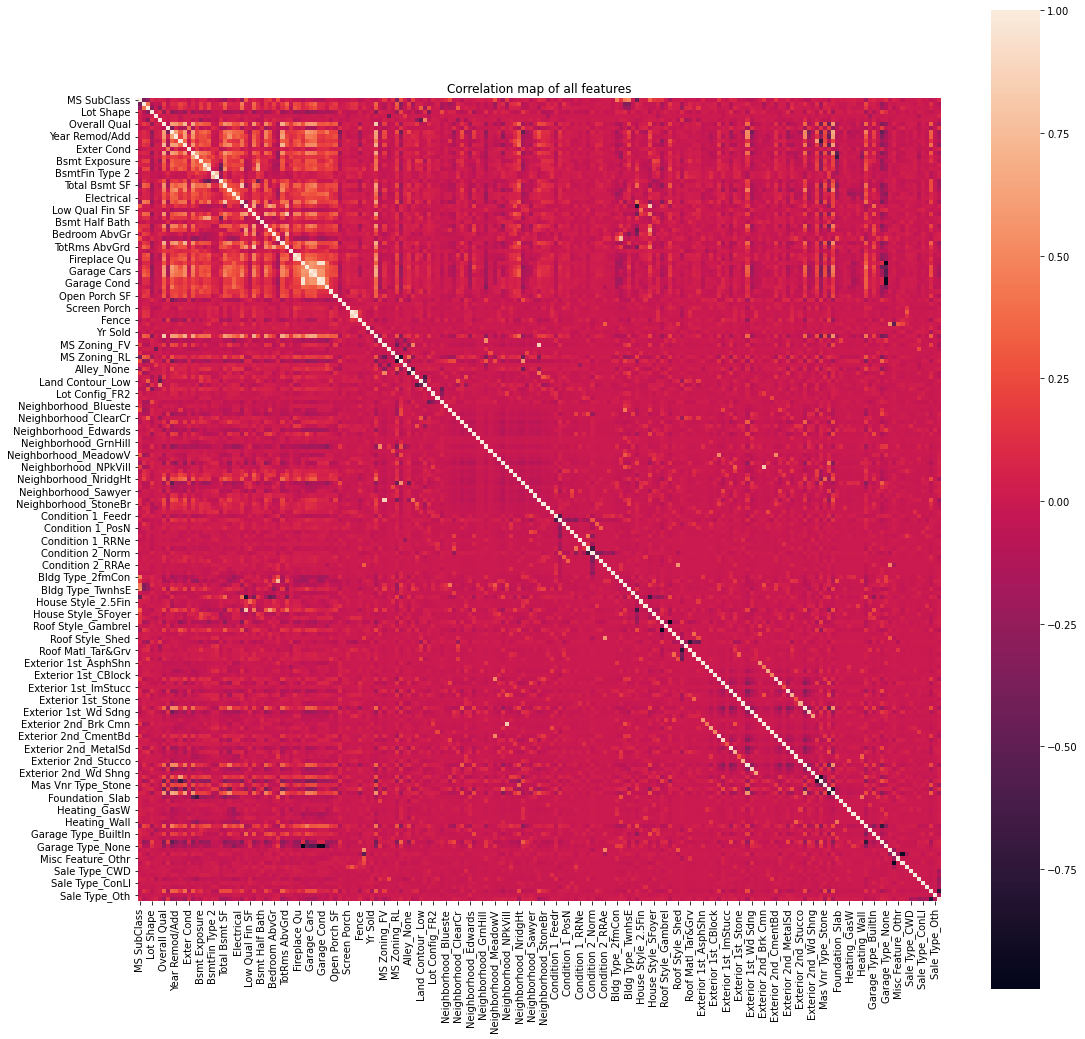

In [14]:
correlation_map(df_new,title="Correlation map of all features")

Not very useful, so let's just ignore for now.

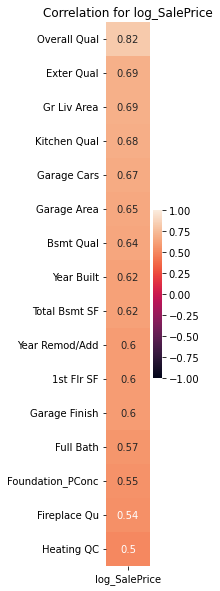

In [15]:
single_correlation_map(df_new,"log_SalePrice")

From the 7 primary variables we had from part 1,  
`Overall Qual`, `Gr Liv Area`, `Garage Cars`, `Year Built`, `Total Bsmt SF`, `Year Remod/Add`, `Full Bath`,   
we now have a few more:  
`Exter Qual`, `Kitchen Qual`, `Bsmt Qual`, `Garage Finish`, `Foundation_PConc`,`Fireplace Qu`, `Heating QC`.

In [16]:
features_to_keep=['Overall Qual','Gr Liv Area','Garage Cars','Year Built','Total Bsmt SF','Year Remod/Add','Full Bath',
             'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Finish', 'Foundation_PConc','Fireplace Qu', 'Heating QC']
#include the label 'SalePrice' as all columns to keep
cols_to_keep=[*features_to_keep,'SalePrice'] 

### Set up model

In [17]:
#retrieve df_train from backup
df_train=df_copy.copy()

#remove missing data
# df_train=df_train.dropna(subset=features_to_keep).reset_index(drop=True)

#set up X and Y
X=df_train.drop(columns="SalePrice")
y=df_train["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

#### Set up a `TransformedTargetRegressor` to handle the log / exponential transformation of the label  
Uses Pipeline to perform preprocessing and prediction

In [18]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model):
    '''
    model:regressor instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('standard_impute',StandardImpute(none=cols_to_impute_with_none,zero=cols_to_impute_with_zero)),
        ('lot_frontage_impute',LotFrontageImpute()),
        ('ordinal_to_numerical',OrdinalToNumeric()),
#         ('numerical_scaling',Scaling()) reserved for scaling
        ('onehotencode',OneHotEncode()),
        ('selector',FeatureSelector(features_to_keep)),
        
#         ('categorical_numerical_split',Categorical_Numerical_Split),
        ('display',DispStep()),
        ('model',model)
    ])
    
    display(pipeline)
        
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1)

In [19]:
lr=create_regressor(LinearRegression())
lr.fit(X, y)

#Look at Training RMSE
X=X_copy.copy()
mean_squared_error(y,lr.predict(X),squared=False)

Pipeline(steps=[('standard_impute',
                 StandardImpute(none=['Pool QC', 'Misc Feature', 'Alley',
                                      'Fence', 'Fireplace Qu', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond',
                                      'Garage Type', 'Bsmt Exposure',
                                      'BsmtFin Type 2', 'Bsmt Cond',
                                      'Bsmt Qual', 'BsmtFin Type 1',
                                      'Mas Vnr Type'],
                                zero=['Garage Yr Blt', 'Mas Vnr Area',
                                      'Bsmt Full Bath', 'Bsmt Half Bath',
                                      'Garage Area', 'Garage Cars',
                                      'Total Bsmt SF', 'Bs...
                ('ordinal_to_numerical', OrdinalToNumeric()),
                ('onehotencode', OneHotEncode()),
                ('selector',
                 FeatureSelector(feature_names=['Overall Qual', 'Gr Liv Area',
                                                'Garage Cars', 'Year Built',
                                                'Total Bsmt SF',
                                                'Year Remod/Add', 'Full Bath',
                                                'Exter Qual', 'Kitchen Qual',
                                                'Bsmt Qual', 'Garage Finish',
                                                'Foundation_PConc',
                                                'Fireplace Qu',
                                                'Heating QC'])),
                ('display', DispStep()), ('model', LinearRegression())])

41990.40212169517

### Try a submission

In [20]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [21]:
#obtain a copy of the test set
df_test=tester.get_test_df()

In [22]:
#make prediction
ypred=lr.predict(df_test)

In [23]:
tester.write_submission(ypred,"../data/02_all_features_submission.csv")

Output saved to ../data/02_all_features_submission.csv
